# BSASELINE

time: 2024-10-06 00:45:00  value: 1115.8175374558577
win rate: 682/1369 = 49.82%
最大连续错误次数: 11


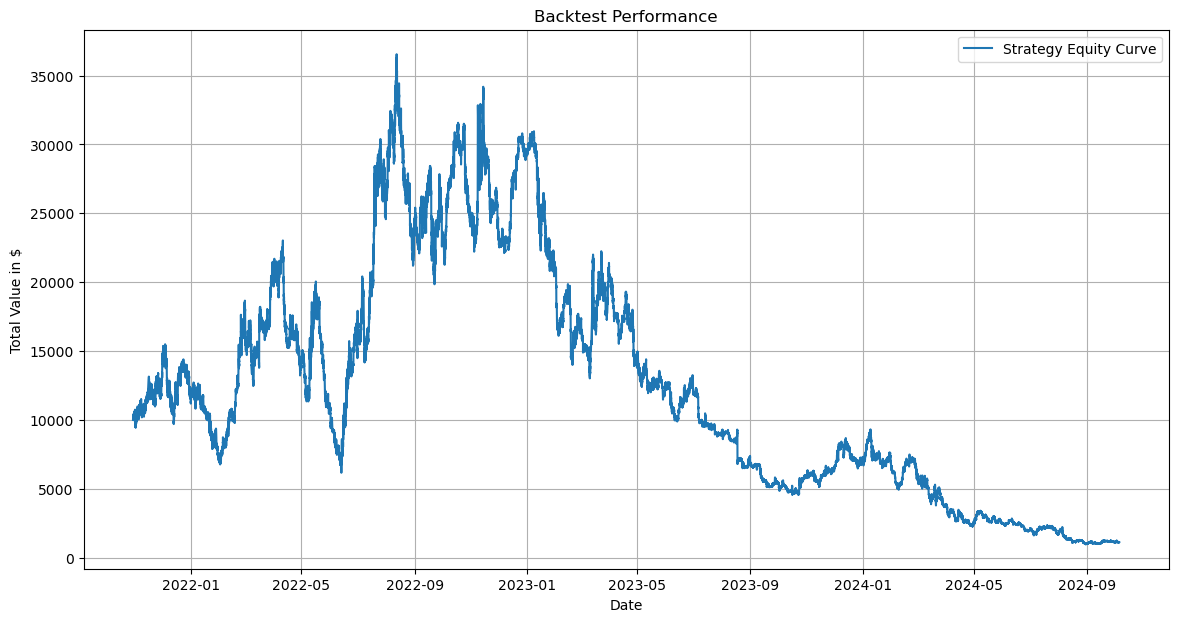

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import clear_output
from sklearn.neural_network import MLPClassifier
df = pd.read_csv('./DATA_original/BTCUSDT_15min.csv')
df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
df.set_index('Date', inplace=True)

lookback_days = 30
waiting_day = 0
start_date = df.index.min() + pd.Timedelta(days=lookback_days)
end_date = start_date + pd.Timedelta(days=182)
# 初始化参数
cash = 10000     # 初始资金
commission_rate = 0.0002  # 交易手续费率（0.03%）
equity_curve2 = []  # 存储策略的资产净值
position = 0       # 持仓状态，0无持仓，1做多，-1做空
shares = 0         # 持有的股票数量
entry_price = 0    # 开仓价格
profitable_trades = 0  # 正收益交易次数
total_trades = 0   # 总交易次数
max_consecutive_losses = 0  # 最大连续错误次数
current_consecutive_losses = 0  # 当前连续错误次数
entry_cash = 10000
upper = 1.02
lower = 0.98

next_trade_day = start_date  # 下一次交易日

for index, row in df.loc[start_date:].iterrows():
    current_price = row['Close']

    # 检查是否是交易日
    if index < next_trade_day:
        equity_curve2.append(total_value)
        continue

    # 交易逻辑
    if position == 0:  # 如果当前无持仓
        prediction = np.random.choice([0,1,2])

        # 根据模型预测决定交易
        if prediction == 2:  # 做多
            total_trades += 1  # 开始一次新的交易
            entry_cash = cash

            shares = cash * 2 / current_price
            commission = shares * current_price * commission_rate
            cash -= shares * current_price + commission
            position = 1
            entry_price = current_price
        elif prediction == 1:  # 做空
            total_trades += 1  # 开始一次新的交易
            entry_cash = cash

            shares = -cash * 2 / current_price
            commission = -shares * current_price * commission_rate
            cash -= shares * current_price + commission
            position = -1
            entry_price = current_price
        elif prediction == 0:  # 不交易，等待两天
            next_trade_day = index + pd.Timedelta(days=waiting_day)

        

    elif position != 0:  # 检查是否平仓
        stop_loss = entry_price * (lower if position == 1 else upper)
        take_profit = entry_price * (upper if position == 1 else lower)
        if (current_price< lower*entry_price or current_price> upper* entry_price):
            # if position == 1:
            cash += shares * current_price - shares * current_price * commission_rate
            if cash > entry_cash:  # 如果平仓后的资金比开仓前高，计为正收益
                profitable_trades += 1
                if current_consecutive_losses > max_consecutive_losses:
                    max_consecutive_losses = current_consecutive_losses  # 更新最大连续错误次数
                current_consecutive_losses = 0  # 重置当前连续错误次数
            else:
                current_consecutive_losses += 1  # 增加连续错误次数
            # else:
            #     cash += (entry_price - current_price) * shares - (entry_price - current_price) * shares * commission_rate
            position = 0
            shares = 0
    

    # 更新总资产
    total_value = cash + shares * current_price
    equity_curve2.append(total_value)
    clear_output(wait=False)  
    print('time:', index,' value:',total_value)
    print(f"win rate: {profitable_trades}/{total_trades} = {profitable_trades/total_trades if total_trades > 0 else 0:.2%}")
    print(f"最大连续错误次数: {max_consecutive_losses}")


# 绘制回测曲线
plt.figure(figsize=(14, 7))
plt.plot(df.loc[start_date:].index, equity_curve2, label='Strategy Equity Curve')
plt.title('Backtest Performance')
plt.xlabel('Date')
plt.ylabel('Total Value in $')
plt.legend()
plt.grid(True)
plt.show()

## functions

In [17]:
import pandas as pd
import numpy as np
import talib
import datetime
def calculate_bollinger_bands(df, short_n=20, long_n=50, num_std=2):
    # Copy the DataFrame to avoid changing the original data
    df = df.copy()

    # Calculate short-term Bollinger Bands
    df['MA'] = df['Close'].rolling(window=short_n).mean()
    df['SD'] = df['Close'].rolling(window=short_n).std()
    df['UBB'] = df['MA'] + (df['SD'] * num_std)
    df['LBB'] = df['MA'] - (df['SD'] * num_std)

    # Store short-term bands temporarily
    short_UBB = df['UBB']
    short_LBB = df['LBB']
    short_MA = df['MA']

    # Calculate long-term Bollinger Bands
    df['MA'] = df['Close'].rolling(window=long_n).mean()
    df['SD'] = df['Close'].rolling(window=long_n).std()
    long_UBB = df['MA'] + (df['SD'] * num_std)
    long_LBB = df['MA'] - (df['SD'] * num_std)

    # Calculate BBTrend
    df['BBT'] = (abs(short_LBB - long_LBB) - abs(short_UBB - long_UBB)) / short_MA * 100

    # Clean up by dropping temporary columns and restoring original MA and Bollinger Bands
    df.drop(['SD'], axis=1, inplace=True)
    df['MA'] = short_MA
    df['UBB'] = short_UBB
    df['LBB'] = short_LBB

    return df

def calculate_rsi(df, column='Close', periods=14):

    # First calculate the price differences
    delta = df[column].diff(1)
    
    # Make two series: one for gains and the other for losses
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    # Use exponential moving average (EMA) instead of simple moving average
    avg_gain = gain.ewm(com=periods-1, min_periods=periods).mean()
    avg_loss = loss.ewm(com=periods-1, min_periods=periods).mean()
    
    # Calculate RS
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Append RSI to the dataframe
    df['RSI'] = rsi
    
    return df

# df = calculate_rsi(df, 'Close', 14)

def calculate_ultimate_oscillator(df, short=7, medium=14, long=28):

    # Calculate true low, buying pressure, and true range
    df['TrueLow'] = df[['Low', 'Close']].shift().min(axis=1)
    df['BuyingPressure'] = df['Close'] - df['TrueLow']
    df['TrueRange'] = df[['High', 'Low']].apply(lambda x: x['High'] - x['Low'], axis=1).combine_first(df['High'] - df['Close'].shift()).combine_first(df['Low'] - df['Close'].shift()).abs()

    # Calculate averages of BP/TR ratios
    df['AvgBP_TR_short'] = df['BuyingPressure'].rolling(window=short).sum() / df['TrueRange'].rolling(window=short).sum()
    df['AvgBP_TR_medium'] = df['BuyingPressure'].rolling(window=medium).sum() / df['TrueRange'].rolling(window=medium).sum()
    df['AvgBP_TR_long'] = df['BuyingPressure'].rolling(window=long).sum() / df['TrueRange'].rolling(window=long).sum()

    # Calculate Ultimate Oscillator
    df['Ultimate_Oscillator'] = 100 * ((4 * df['AvgBP_TR_short'] + 2 * df['AvgBP_TR_medium'] + df['AvgBP_TR_long']) / 7)

    # Clean up the DataFrame
    df.drop(['TrueLow', 'BuyingPressure', 'TrueRange', 'AvgBP_TR_short', 'AvgBP_TR_medium', 'AvgBP_TR_long'], axis=1, inplace=True)
    
    return df


# df = calculate_ultimate_oscillator(df)
def calculate_close_price_percentage_variation(df, column='Close'):

    # Calculate the percentage change from the previous close
    df['Close_Price_Percent_Change'] = df[column].pct_change() * 100
    
    return df

# df = calculate_close_price_percentage_variation(df)
def calculate_z_score(df, column='Close', window=30):

    # Calculate the rolling mean and standard deviation
    df['Mean'] = df[column].rolling(window=window).mean()
    df['Std'] = df[column].rolling(window=window).std()
    
    # Calculate Z-Score
    df['Z-Score'] = (df[column] - df['Mean']) / df['Std']
    
    # Clean up the DataFrame by dropping the intermediate columns
    df.drop(['Mean', 'Std'], axis=1, inplace=True)
    
    return df

# df = calculate_z_score(df)

def calculate_ema_crossovers(df, column='Close'):
    # Calculate EMAs
    df['EMA_1'] = df[column].ewm(span=1, adjust=False).mean()
    df['EMA_20'] = df[column].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df[column].ewm(span=50, adjust=False).mean()
    df['EMA_100'] = df[column].ewm(span=100, adjust=False).mean()
    
    # Calculate Crossover Indicators
    df['Cross_1_20'] = (df['EMA_1'] > df['EMA_20']).astype(int) - (df['EMA_1'] < df['EMA_20']).astype(int)
    df['Cross_20_50'] = (df['EMA_20'] > df['EMA_50']).astype(int) - (df['EMA_20'] < df['EMA_50']).astype(int)
    df['Cross_50_100'] = (df['EMA_50'] > df['EMA_100']).astype(int) - (df['EMA_50'] < df['EMA_100']).astype(int)
    df['Cross_1_50'] = (df['EMA_1'] > df['EMA_50']).astype(int) - (df['EMA_1'] < df['EMA_50']).astype(int)
    
    return df

# df = calculate_ema_crossovers(df)
def add_time_indicators(df):
    # Temporarily convert timestamp to datetime for extraction

    temp_datetime = pd.to_datetime(df['Open time'], unit='ms')


    # Extract month, day of the week, and hour from the datetime
    df['month'] = temp_datetime.dt.month - 1  # Adjust to 0-11
    df['DayOfWeek'] = temp_datetime.dt.dayofweek  # Monday=0, Sunday=6
    df['hourly'] = temp_datetime.dt.hour  # Hour of the day 0-23
    
    return df

def calculate_indicator(df):
    df= calculate_bollinger_bands(df, short_n=20, long_n=50, num_std=2)
    df = calculate_rsi(df, 'Close', 14)
    df = calculate_ultimate_oscillator(df)
    df = calculate_close_price_percentage_variation(df)
    df = calculate_z_score(df)
    df = calculate_ema_crossovers(df)
    df = add_time_indicators(df)
    # 定义蜡烛图模式的列表
    candle_names = [
        "CDL2CROWS", "CDL3BLACKCROWS", "CDL3WHITESOLDIERS", "CDLABANDONEDBABY", "CDLBELTHOLD",
        "CDLCOUNTERATTACK", "CDLDARKCLOUDCOVER", "CDLDRAGONFLYDOJI", "CDLENGULFING",
        "CDLEVENINGDOJISTAR", "CDLEVENINGSTAR", "CDLGRAVESTONEDOJI", "CDLHANGINGMAN",
        "CDLHARAMICROSS", "CDLINVERTEDHAMMER", "CDLMARUBOZU", "CDLMORNINGDOJISTAR",
        "CDLMORNINGSTAR", "CDLPIERCING", "CDLRISEFALL3METHODS", "CDLSHOOTINGSTAR",
        "CDLSPINNINGTOP", "CDLUPSIDEGAP2CROWS"
    ]

    # 初始化一个空的DataFrame来存储每个蜡烛图模式的结果
    pattern_data = pd.DataFrame(index=df.index)

    # 计算每个蜡烛图模式并将结果添加到pattern_data中
    for name in candle_names:
        pattern_function = getattr(talib, name)
        pattern_data[name] = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])/100
    df = df.join(pattern_data)
    return df

def generate_data_set(dftemp, upper, lower):
    scalar_columns = ['MA', 'UBB', 'LBB', 'BBT', 'RSI', 
                      'Z-Score', 'Cross_1_20', 'Cross_20_50', 'Cross_50_100', 'Cross_1_50', 'month', 
                      'DayOfWeek', 'hourly',
                      'Ultimate_Oscillator', 'Close_Price_Percent_Change',
                      'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY',
                      'CDLBELTHOLD', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 
                      'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGRAVESTONEDOJI', 'CDLHANGINGMAN', 'CDLHARAMICROSS', 
                      'CDLINVERTEDHAMMER', 'CDLMARUBOZU', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLPIERCING', 
                      'CDLRISEFALL3METHODS', 'CDLSHOOTINGSTAR', 'CDLSPINNINGTOP', 'CDLUPSIDEGAP2CROWS']
    time = 'Open time'
    num_samples = 7000
    total_rows = len(dftemp)
    window_length = 72  # Time window length

    # Adjust max_start_index to exclude the test data
    max_start_index = total_rows - window_length-1
    if max_start_index <= 0:
        raise ValueError("Not enough data to generate training samples.")

    # Generate start_indices from max_start_index down to window_length
    interval = max(max_start_index // num_samples, 1)  # Avoid interval 0
    start_indices = np.arange(max_start_index, window_length - 1, -interval)

    # Reverse start_indices to start from the most recent data
    start_indices = start_indices[::-1][:num_samples]

    # Initialize data storage structures
    num_samples = len(start_indices)
    scalar_data = np.empty((num_samples, len(scalar_columns) + 2))
    time_data = np.empty(num_samples, dtype=object)
    labels = np.empty(num_samples, dtype=int)  # Store labels

    for i, start_index in enumerate(start_indices):
        end_index = start_index + window_length

        # Ensure indices are within bounds
        if end_index - 1 >= total_rows:
            continue  # Skip if end_index is out of bounds

        scalar_data[i, :-2] = dftemp.loc[end_index - 1, scalar_columns].values
        time_data[i] = dftemp.loc[end_index - 1, time]

        # Compute 'Number of trades' mean and variance
        number_of_trades_stats = dftemp.loc[start_index:end_index - 1, 'Number of trades']
        scalar_data[i, -2] = number_of_trades_stats.mean()
        scalar_data[i, -1] = number_of_trades_stats.var()

        # Label generation logic
        subsequent_open_prices = dftemp.loc[end_index:, 'Close'].values
        if len(subsequent_open_prices) > window_length:
            subsequent_open_prices = subsequent_open_prices[:window_length]
        if len(subsequent_open_prices) == 0:
            labels[i] = 0  # No data to compute label
            continue
        if len(subsequent_open_prices) < window_length:

            initial_open_price = subsequent_open_prices[0]
            upper_bound = initial_open_price * upper
            lower_bound = initial_open_price * lower
            label_set = False
            for price in subsequent_open_prices:
                if price >= upper_bound:
                    labels[i] = 2  # Price increased by 1%
                    label_set = True
                    break
                elif price <= lower_bound:
                    labels[i] = 1  # Price decreased by 1%
                    label_set = True
                    break

            if not label_set:
                labels[i] = -1
        else:
            initial_open_price = subsequent_open_prices[0]
            upper_bound = initial_open_price * upper
            lower_bound = initial_open_price * lower

            # Traverse available price data
            label_set = False
            for price in subsequent_open_prices:
                if price >= upper_bound:
                    labels[i] = 2  # Price increased by 1%
                    label_set = True
                    break
                elif price <= lower_bound:
                    labels[i] = 1  # Price decreased by 1%
                    label_set = True
                    break

            if not label_set:
                labels[i] = 0  # Price didn't cross thresholds

    # Prepare test features (without labels)
    valid_indices = labels != -1
    # 使用布尔索引过滤数据
    filtered_scalar_data = scalar_data[valid_indices]
    filtered_labels = labels[valid_indices]
    test_index = total_rows-1
    test_features = dftemp.loc[test_index, scalar_columns].values
    test_time = dftemp.loc[test_index, time]
    print("time gap = ",  datetime.timedelta(milliseconds=int(test_time - time_data[-1])))
    # Compute 'Number of trades' mean and variance for test data
    test_number_of_trades = dftemp.loc[test_index-window_length+1: test_index, 'Number of trades']
    test_mean = test_number_of_trades.mean()
    test_var = test_number_of_trades.var()
    test_scalar_data = np.append(test_features, [test_mean, test_var]).reshape(1, -1)

    return filtered_scalar_data, filtered_labels, test_scalar_data


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import clear_output
df = pd.read_csv('BTCUSDT_15min.csv')
df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
df.set_index('Date', inplace=True)

lookback_days = 60
start_date = df.index.min() + pd.Timedelta(days=lookback_days)
end_date = start_date + pd.Timedelta(days=182)
# 初始化参数
cash = 10000     # 初始资金
commission_rate = 0.0003  # 交易手续费率（0.03%）
equity_curve = []  # 存储策略的资产净值
position = 0       # 持仓状态，0无持仓，1做多，-1做空
shares = 0         # 持有的股票数量
entry_price = 0    # 开仓价格
upper = 1.02
lower = 0.98
# 回测循环
for index in df.loc[start_date:].index:
# for index in df.loc[start_date:end_date].index:
    # 获取过去一个月的df子集
    row = df.loc[index]
    current_price = row['Close']
    if position == 0:
        df_sub = df.loc[index - pd.Timedelta(days=lookback_days):index]
        df_sub = df_sub.reset_index(drop=True)
        df_sub = calculate_indicator(df_sub)
        scalar_data, labels, test_scalar_data = generate_data_set(df_sub,upper,lower)
        model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            eval_metric='mlogloss',
            n_estimators=200,
            max_depth=6,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=10,   # 使用 reg_lambda 替代 lambda
            reg_alpha=1,  # 使用 reg_alpha 替代 alpha
            learning_rate=0.1
            )
        model.fit(scalar_data, labels)
        y_pred_proba = model.predict_proba(test_scalar_data)

        # 设置阈值
        threshold_for_class_1 = 0.7
        threshold_for_class_2 = 0.7
        # 根据阈值应用分类逻辑
        y_pred = []
        for proba in y_pred_proba:
            if proba[1] >= threshold_for_class_1 and proba[1] > proba[2]:
                y_pred.append(1)
            elif proba[2] >= threshold_for_class_2 and proba[2] > proba[1]:
                y_pred.append(2)
            else:
                y_pred.append(0)  # 

        y_pred = np.array(y_pred)
                # 对测试样本进行预测
        # y_pred = model.predict(test_scalar_data)
        prediction = y_pred[0]
    # prediction = np.random.choice([0, 1, 2])  # 随机模拟模型的预测
    # 如果您有模型预测，可以在这里使用df_sub进行预测
    if position == 0:  # 检查是否开仓
        if prediction == 2:  # 做多
            shares = cash*2 / current_price
            commission = shares * current_price * commission_rate
            cash -= shares * current_price + commission  # 防止溢出
            position = 1
            entry_price = current_price
        elif prediction == 1:  # 做空
            shares = -cash*2 / current_price
            commission = shares * current_price * commission_rate
            cash -= shares * current_price - commission  # 防止溢出
            position = -1
            entry_price = current_price
            

    elif position != 0:  # 检查是否平仓
        stop_loss = entry_price * (lower if position == 1 else upper)
        take_profit = entry_price * (upper if position == 1 else lower)
        if (current_price< lower*entry_price or current_price> upper* entry_price):
            # if position == 1:
            cash += shares * current_price - shares * current_price * commission_rate
            # else:
            #     cash += (entry_price - current_price) * shares - (entry_price - current_price) * shares * commission_rate
            position = 0
            shares = 0
    
    total_value = cash + shares * current_price
    clear_output(wait=False)  
    print('time:', index,' value:',total_value)
    equity_curve.append(total_value)

print(equity_curve)
# 绘制回测曲线
plt.figure(figsize=(14, 7))
plt.plot(df.loc[start_date:].index, equity_curve, label='Strategy Equity Curve')
plt.title('Backtest Performance')
plt.xlabel('Date')
plt.ylabel('Total Value in $')
plt.legend()
plt.grid(True)
plt.show()

time: 2021-11-29 00:30:00  value: 9547.40498997179
time gap =  0:15:00
5689    10040
5690    11584
5691     8703
5692    14535
5693    12556
        ...  
5756    27664
5757    50177
5758    49259
5759    62434
5760    38980
Name: Number of trades, Length: 72, dtype: int64


KeyboardInterrupt: 

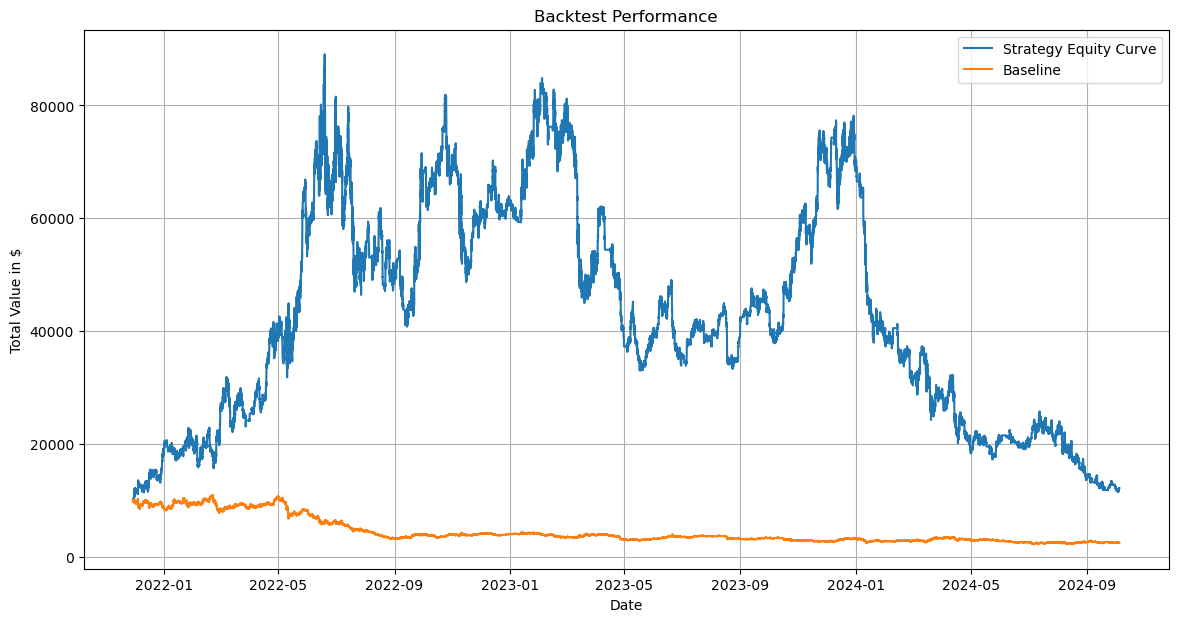

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(df.loc[start_date:].index, equity_curve, label='Strategy Equity Curve')
plt.plot(df.loc[start_date:].index, equity_curve2, label='Baseline')
plt.title('Backtest Performance')
plt.xlabel('Date')
plt.ylabel('Total Value in $')
plt.legend()
plt.grid(True)
plt.show()

## fast test

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import clear_output
from sklearn.neural_network import MLPClassifier
df = pd.read_csv('BTCUSDT_1h.csv')
df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
df.set_index('Date', inplace=True)

waiting_day = 0
lookback_days = 30
start_date = df.index.min() + pd.Timedelta(days=lookback_days)
end_date = start_date + pd.Timedelta(days=182)
# 初始化参数
cash = 10000     # 初始资金
commission_rate = 0.0002  # 交易手续费率（0.03%）
equity_curve2 = []  # 存储策略的资产净值
position = 0       # 持仓状态，0无持仓，1做多，-1做空
shares = 0         # 持有的股票数量
entry_price = 0    # 开仓价格
profitable_trades = 0  # 正收益交易次数
total_trades = 0   # 总交易次数
max_consecutive_losses = 0  # 最大连续错误次数
current_consecutive_losses = 0  # 当前连续错误次数
predict_0_count = 0  # 预测为0的次数
predict_1_count = 0  # 预测为1的次数
predict_2_count = 0  # 预测为2的次数
entry_cash = 10000
upper = 1.03
lower = 0.97

next_trade_day = start_date  # 下一次交易日

for index, row in df.loc[start_date:].iterrows():
    current_price = row['Close']

    # 检查是否是交易日
    if index < next_trade_day:
        equity_curve2.append(total_value)
        continue

    # 交易逻辑
    if position == 0:  # 如果当前无持仓
        df_sub = df.loc[index - pd.Timedelta(days=lookback_days):index]
        df_sub = df_sub.reset_index(drop=True)
        df_sub = calculate_indicator(df_sub)
        scalar_data, labels, test_scalar_data = generate_data_set(df_sub,upper,lower)
        model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            eval_metric='mlogloss',
            n_estimators=200,
            max_depth=6,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=10,   # 使用 reg_lambda 替代 lambda
            reg_alpha=1,  # 使用 reg_alpha 替代 alpha
            learning_rate=0.1
            )
        model.fit(scalar_data, labels)
        y_pred_proba = model.predict_proba(test_scalar_data)

        # 设置阈值
        threshold_for_class_1 = 0.7
        threshold_for_class_2 = 0.7
        # 根据阈值应用分类逻辑
        y_pred = []
        for proba in y_pred_proba:
            if proba[1] >= threshold_for_class_1 and proba[1] > proba[2]:
                y_pred.append(1)
            elif proba[2] >= threshold_for_class_2 and proba[2] > proba[1]:
                y_pred.append(2)
            else:
                y_pred.append(0)  # 

        y_pred = np.array(y_pred)
                # 对测试样本进行预测
        # y_pred = model.predict(test_scalar_data)
        prediction = y_pred[0]

        # 根据模型预测决定交易
        if prediction == 2:  # 做多
            total_trades += 1  # 开始一次新的交易
            entry_cash = cash

            shares = cash * 1 / current_price
            commission = shares * current_price * commission_rate
            cash -= shares * current_price + commission
            position = 1
            entry_price = current_price
            predict_2_count +=1
        elif prediction == 1:  # 做空
            total_trades += 1  # 开始一次新的交易
            entry_cash = cash

            shares = -cash * 1 / current_price
            commission = -shares * current_price * commission_rate
            cash -= shares * current_price + commission
            position = -1
            entry_price = current_price
            predict_1_count +=1
        elif prediction == 0:  # 不交易，等待两天
            next_trade_day = index + pd.Timedelta(days=waiting_day)
            predict_0_count +=1

        

    elif position != 0:  # 检查是否平仓
        stop_loss = entry_price * (lower if position == 1 else upper)
        take_profit = entry_price * (upper if position == 1 else lower)
        if (current_price< lower*entry_price or current_price> upper* entry_price):
            # if position == 1:
            cash += shares * current_price - shares * current_price * commission_rate
            if cash > entry_cash:  # 如果平仓后的资金比开仓前高，计为正收益
                profitable_trades += 1
                if current_consecutive_losses > max_consecutive_losses:
                    max_consecutive_losses = current_consecutive_losses  # 更新最大连续错误次数
                current_consecutive_losses = 0  # 重置当前连续错误次数
            else:
                current_consecutive_losses += 1  # 增加连续错误次数
            # else:
            #     cash += (entry_price - current_price) * shares - (entry_price - current_price) * shares * commission_rate
            position = 0
            shares = 0
    

    # 更新总资产
    total_value = cash + shares * current_price
    equity_curve2.append(total_value)
    clear_output(wait=False)  
    print('time:', index,' value:',total_value)
    print(f"win rate: {profitable_trades}/{total_trades} = {profitable_trades/total_trades if total_trades > 0 else 0:.2%}")
    print(f"最大连续错误次数: {max_consecutive_losses}")
    print(f"0:  {predict_0_count / (predict_0_count+predict_1_count+predict_2_count) :.1%}")
    print(f"1:  {predict_1_count / (predict_0_count+predict_1_count+predict_2_count) :.1%}")
    print(f"2:  {predict_2_count / (predict_0_count+predict_1_count+predict_2_count) :.1%}")

# 绘制回测曲线
plt.figure(figsize=(14, 7))
plt.plot(df.loc[start_date:].index, equity_curve2, label='Strategy Equity Curve')
plt.title('Backtest Performance')
plt.xlabel('Date')
plt.ylabel('Total Value in $')
plt.legend()
plt.grid(True)
plt.show()

time: 2022-03-09 01:00:00  value: 7295.8863253371965
win rate: 47/99 = 47.47%
最大连续错误次数: 7
0:  66.4%
1:  19.3%
2:  14.2%
time gap =  1:00:00


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

In [38]:
df = pd.read_csv('BTCUSDT_klines_and_volume.csv')